
Top 20 Highest AR/Revenue Companies:

                                                 name  AR_to_Revenue
421                                   US BANCORP \DE\       6.844574
171                               FIFTH THIRD BANCORP       5.719074
138                       DISCOVER FINANCIAL SERVICES       4.169691
397                                SUNTRUST BANKS INC       3.665255
286                         MERRILL LYNCH & CO., INC.       3.458527
168  FEDERAL NATIONAL MORTGAGE ASSOCIATION FANNIE MAE       3.140880
55                          BANK OF AMERICA CORP /DE/       3.121479
238                             J P MORGAN CHASE & CO       2.977890
312                                     NYSE EURONEXT       2.594563
320                                        PACCAR INC       2.528650
249                                 KIMCO REALTY CORP       2.438265
176                                  FLIR SYSTEMS INC       2.294425
76                                      BROADCOM CORP       2.28

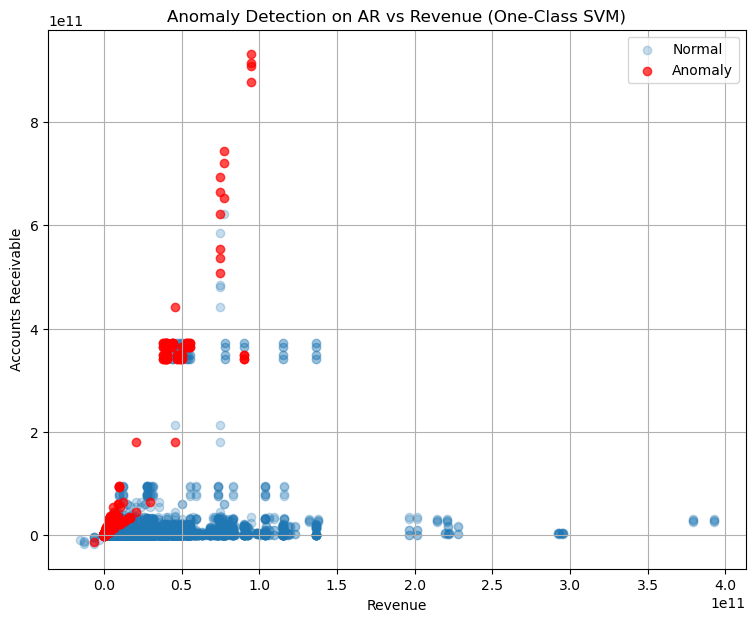


Top 20 Most Suspicious Companies Based on Ratio:

                                  name  AR_to_Revenue
19752                      EXELON CORP      10.000000
13582               PEPCO HOLDINGS INC      10.000000
19174                      EXELON CORP      10.000000
24987  BOARDWALK PIPELINE PARTNERS, LP      10.000000
31676                ADOBE SYSTEMS INC       9.998504
31677                ADOBE SYSTEMS INC       9.998504
34031              HARLEY DAVIDSON INC       9.991021
9893                  MASSEY ENERGY CO       9.979932
6511                     FORD MOTOR CO       9.977263
6247                     FORD MOTOR CO       9.977263
7612     GENERAL GROWTH PROPERTIES INC       9.965925
20100              FIFTH THIRD BANCORP       9.965116
8199                    LEGG MASON INC       9.960460
34015              HARLEY DAVIDSON INC       9.958693
35354       MEDCO HEALTH SOLUTIONS INC       9.955569
12395           BERKSHIRE HATHAWAY INC       9.950000
20661  PLAINS ALL AMERICAN PIPE

In [ ]:
import pandas as pd ##pandas used for data analysis 
import numpy as np ##numpy used for numerical operations
import matplotlib.pyplot as plt ##matplotlib used for plotting
from sklearn.svm import OneClassSVM ##import one-class SVM from sklearn
from sklearn.preprocessing import StandardScaler ##import StandardScaler for data scaling

##path to dataset
path = "/home/codysch/Downloads/2009q4/"

##sub=loads company metadata(names, identifiers, formt types)
##num=loads all numeric financial data(revenue, AR, assets, etc.)
##use memory=False to handle large files(especially with low RAM systems)
sub = pd.read_csv(path + "sub.txt", sep="\t", low_memory=False)
num = pd.read_csv(path + "num.txt", sep="\t", low_memory=False, on_bad_lines="skip")

##merge the two so you get name + values together
merged = pd.merge(num, sub, on="adsh")

##filter to just revenue and accounts receivable
rev = merged[merged["tag"].str.contains("Revenue", case=False, na=False)]
rec = merged[merged["tag"].str.contains("Receivable", case=False, na=False)]

##merges revenue + AR together
##adsh=accession number(unique filing identifier)
##cik=company identifier
##name=company name
##period=fiscal period
##rev=revenue data
##rec=accounts receivable data
paired = pd.merge(
    rev,
    rec,
    on=["adsh", "cik", "name", "period"],
    suffixes=("_rev", "_rec")
)

##calculate AR to Revenue ratio
##the equation we ended up using is AR / Revenue as coded below
paired["AR_to_Revenue"] = paired["value_rec"] / paired["value_rev"]

##keep only reasonable ratios (0-10), for example AR > 10 * Revenue is likely a data error
paired = paired[paired["AR_to_Revenue"].between(0, 10)]

##prepare data for SVM, this extracts just the ratio column for the SVM
X = paired[["AR_to_Revenue"]].values

##Scale the data, one class SVM requires scaled data for best results
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

##train the one-class SVM
##kernel="rbf" is the radial basis function kernel, good for non-linear data , which is common in financial ratios
##gamma="auto" sets the gamma parameter automatically based on features, which is useful for general cases
##nu=0.05 sets the expected proportion of outliers (5% here)
ocsvm = OneClassSVM(kernel="rbf", gamma="auto", nu=0.05)
ocsvm.fit(X_scaled)

##predict anomalies
paired["anomaly"] = ocsvm.predict(X_scaled)

## Split normal and anomalous data
sus = paired[paired["anomaly"] == -1]
normal = paired[paired["anomaly"] == 1]

##summary of average ratios by company
##this shows each company's average AR/Revenue ratio across all periods
##the highest ratios may indicate companies with consistently high receivables relative to revenue which indicates potential issues
summary = (
    paired.groupby("name")["AR_to_Revenue"]
    .mean()
    .reset_index()
    .sort_values("AR_to_Revenue", ascending=False)
)

##print top 20 companies with highest average AR/Revenue ratio
print("\nTop 20 Highest AR/Revenue Companies:\n")
print(summary.head(20))



##this plots revenue vs accounts receivable as well as highlighting anomalies detected by the one-class SVM
plt.figure(figsize=(9,7))##plot size
plt.scatter(normal["value_rev"], normal["value_rec"], alpha=0.25, label="Normal")##plot normal points
plt.scatter(sus["value_rev"], sus["value_rec"], color="red", alpha=0.7, label="Anomaly")##plot anomalies in red
plt.xlabel("Revenue")##plot labels for revenue
plt.ylabel("Accounts Receivable")##plot labels for accounts receivable  
plt.title("Anomaly Detection on AR vs Revenue (One-Class SVM)")##plot title
plt.legend()##show legend
plt.grid(True)##show grid
plt.show()##display plot

##print top 20 most suspicious companies based on AR/Revenue ratio
sus_sorted = sus.sort_values("AR_to_Revenue", ascending=False)##sorts suspicious companies by ratio
print("\nTop 20 Most Suspicious Companies Based on Ratio:\n")##print header
print(sus_sorted[["name", "AR_to_Revenue"]].head(20))##print top 20 companies with highest ratios




In [3]:
X

array([[0.        ],
       [0.        ],
       [0.        ],
       ...,
       [0.01739864],
       [0.45553954],
       [0.01683657]])

In [4]:
sub

,adsh,cik,name,sic,countryba,stprba,cityba,zipba,bas1,bas2,...,period,fy,fp,filed,accepted,prevrpt,detail,instance,nciks,aciks
0,0001047469-09-009543,24545,MOLSON COORS BREWING CO,2082,US,CO,GOLDEN,80401,"P.O. BOX 4030, MAIL #NH375",NaN,...,20090930,2009.0,Q3,20091105,2009-11-04 21:16:00.0,0,0,tap-20090926.xml,1,NaN
1,0001047469-09-009754,831001,CITIGROUP INC,6021,US,NY,NEW YORK,10043,399 PARK AVENUE,NaN,...,20090930,2009.0,Q3,20091106,2009-11-06 17:12:00.0,0,0,c-20090930.xml,1,NaN
2,0001157523-09-007839,1067983,BERKSHIRE HATHAWAY INC,6331,US,NE,OMAHA,68131,1440 KIEWIT PLZ,NaN,...,20090930,2009.0,Q3,20091106,2009-11-06 17:05:00.0,0,0,brka-20090930.xml,1,NaN
3,0000918160-09-000039,918160,AK STEEL HOLDING CORP,3312,US,OH,WEST CHESTER,45069,9227 CENTRE POINTE DRIVE,NaN,...,20090930,2009.0,Q3,20091103,2009-11-03 09:06:00.0,0,0,aks-20090930.xml,1,NaN
4,0001144204-09-056412,1121788,GARMIN LTD,3812,KY,NaN,CAMANA BAY,KY1-1006,"PO BOX 10670, GRAND CAYMAN KY1-1006","STE. 3206B, 45 MARKET ST., GARDENIA CT.",...,20090930,2009.0,Q3,20091104,2009-11-04 11:11:00.0,0,0,grmn-20090926.xml,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,0001193125-09-224951,63908,MCDONALDS CORP,5812,US,IL,OAK BROOK,60523,ONE MCDONALD'S PLZ,DEPT 332,...,20090930,2009.0,Q3,20091105,2009-11-05 10:42:00.0,0,0,mcd-20090930.xml,1,NaN
480,0001193125-09-225868,106535,WEYERHAEUSER CO,2400,US,WA,FEDERAL WAY,98003,33663 WEYERHAEUSER WAY SOUTH,NaN,...,20090930,2009.0,Q3,20091106,2009-11-05 17:57:00.0,0,0,wy-20090930.xml,1,NaN
481,0001193125-09-227752,1373835,SPECTRA ENERGY CORP.,4923,US,TX,HOUSTON,77056,5400 WESTHEIMER COURT,NaN,...,20090930,2009.0,Q3,20091106,2009-11-06 17:13:00.0,0,0,se-20090930.xml,1,NaN
482,0001193125-09-213071,1065280,NETFLIX INC,7841,US,CA,LOS GATOS,95032,100 WINCHESTER CIRCLE,.,...,20090930,2009.0,Q3,20091026,2009-10-23 21:12:00.0,0,0,nflx-20090930.xml,1,NaN


In [5]:
rev

,adsh,tag,version,ddate,qtrs,uom,segments,coreg,value,footnote,...,period,fy,fp,filed,accepted,prevrpt,detail,instance,nciks,aciks
9,0000040545-09-000074,SalesRevenueGoodsNet,us-gaap/2009,20090930,3,USD,LegalEntity=SubsidiariesGECS;,SubsidiariesGECS,6.910000e+08,NaN,...,20090930,2009.0,Q3,20091106,2009-11-06 11:58:00.0,0,0,ge-20090930.xml,1,NaN
11,0000040545-09-000074,Revenues,us-gaap/2009,20090930,3,USD,LegalEntity=SubsidiariesGECS;,SubsidiariesGECS,4.066000e+10,NaN,...,20090930,2009.0,Q3,20091106,2009-11-06 11:58:00.0,0,0,ge-20090930.xml,1,NaN
25,0000040545-09-000074,FinancialServicesRevenue,us-gaap/2009,20080930,1,USD,NaN,NaN,1.753000e+10,NaN,...,20090930,2009.0,Q3,20091106,2009-11-06 11:58:00.0,0,0,ge-20090930.xml,1,NaN
47,0000040545-09-000074,SalesRevenueServicesNet,us-gaap/2009,20090930,1,USD,NaN,NaN,1.051600e+10,NaN,...,20090930,2009.0,Q3,20091106,2009-11-06 11:58:00.0,0,0,ge-20090930.xml,1,NaN
66,0000040545-09-000074,FinancialServicesRevenue,us-gaap/2009,20090930,1,USD,LegalEntity=SubsidiariesGECS;,SubsidiariesGECS,1.253300e+10,NaN,...,20090930,2009.0,Q3,20091106,2009-11-06 11:58:00.0,0,0,ge-20090930.xml,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146244,0000038074-09-000048,Revenues,us-gaap/2009,20090930,2,USD,NaN,NaN,2.072085e+09,NaN,...,20090930,2009.0,Q2,20091109,2009-11-09 09:06:00.0,0,0,frx-20090930.xml,1,NaN
146251,0000038074-09-000048,Revenues,us-gaap/2009,20080930,1,USD,NaN,NaN,9.925060e+08,NaN,...,20090930,2009.0,Q2,20091109,2009-11-09 09:06:00.0,0,0,frx-20090930.xml,1,NaN
146252,0000038074-09-000048,Revenues,us-gaap/2009,20090930,1,USD,NaN,NaN,1.063934e+09,NaN,...,20090930,2009.0,Q2,20091109,2009-11-09 09:06:00.0,0,0,frx-20090930.xml,1,NaN
146274,0000950123-09-052756,IncreaseDecreaseInDeferredRevenue,us-gaap/2009,20080930,2,USD,NaN,NaN,-4.280000e+08,NaN,...,20090930,2009.0,Q2,20091023,2009-10-23 16:32:00.0,0,0,ca-20090930.xml,1,NaN


In [11]:
paired["value_rev"]
paired["value_rec"]


0                0.0
1                0.0
2                0.0
5                0.0
8                0.0
            ...     
41609     22964000.0
41610    449444000.0
41611     18511000.0
41612    484664000.0
41613     17913000.0
Name: value_rec, Length: 31300, dtype: float64